In [107]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [108]:
# Load the data
data = pd.read_csv('payment-practicesold.csv')

In [109]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [110]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [111]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10381,42.852425
Average time to pay,2448,10.105263
% Invoices paid within 30 days,2448,10.105263
% Invoices paid between 31 and 60 days,2448,10.105263
% Invoices paid later than 60 days,2448,10.105263
% Invoices not paid within agreed terms,2405,9.927761
Shortest (or only) standard payment period,2405,9.927761
Longest standard payment period,9919,40.945304
Maximum contractual payment period,2405,9.927761
Payment terms have changed,2405,9.927761


Handling missing data

In [112]:
data = data.dropna(subset=['E-Invoicing offered'])

In [113]:
data['Payments made in the reporting period'].fillna(0, inplace=True)

In [114]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [115]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [116]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


EDA

80th Quantile =  51.0


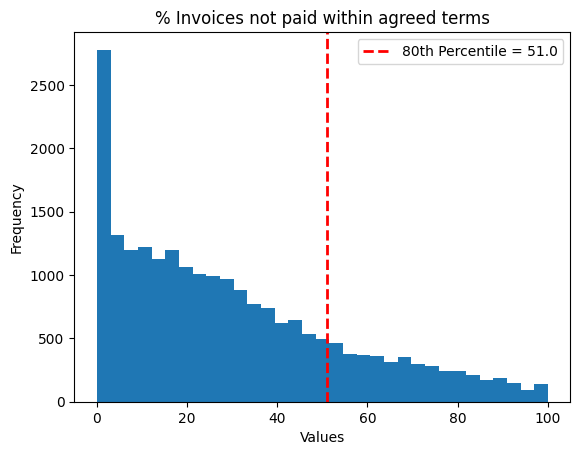

In [117]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [118]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

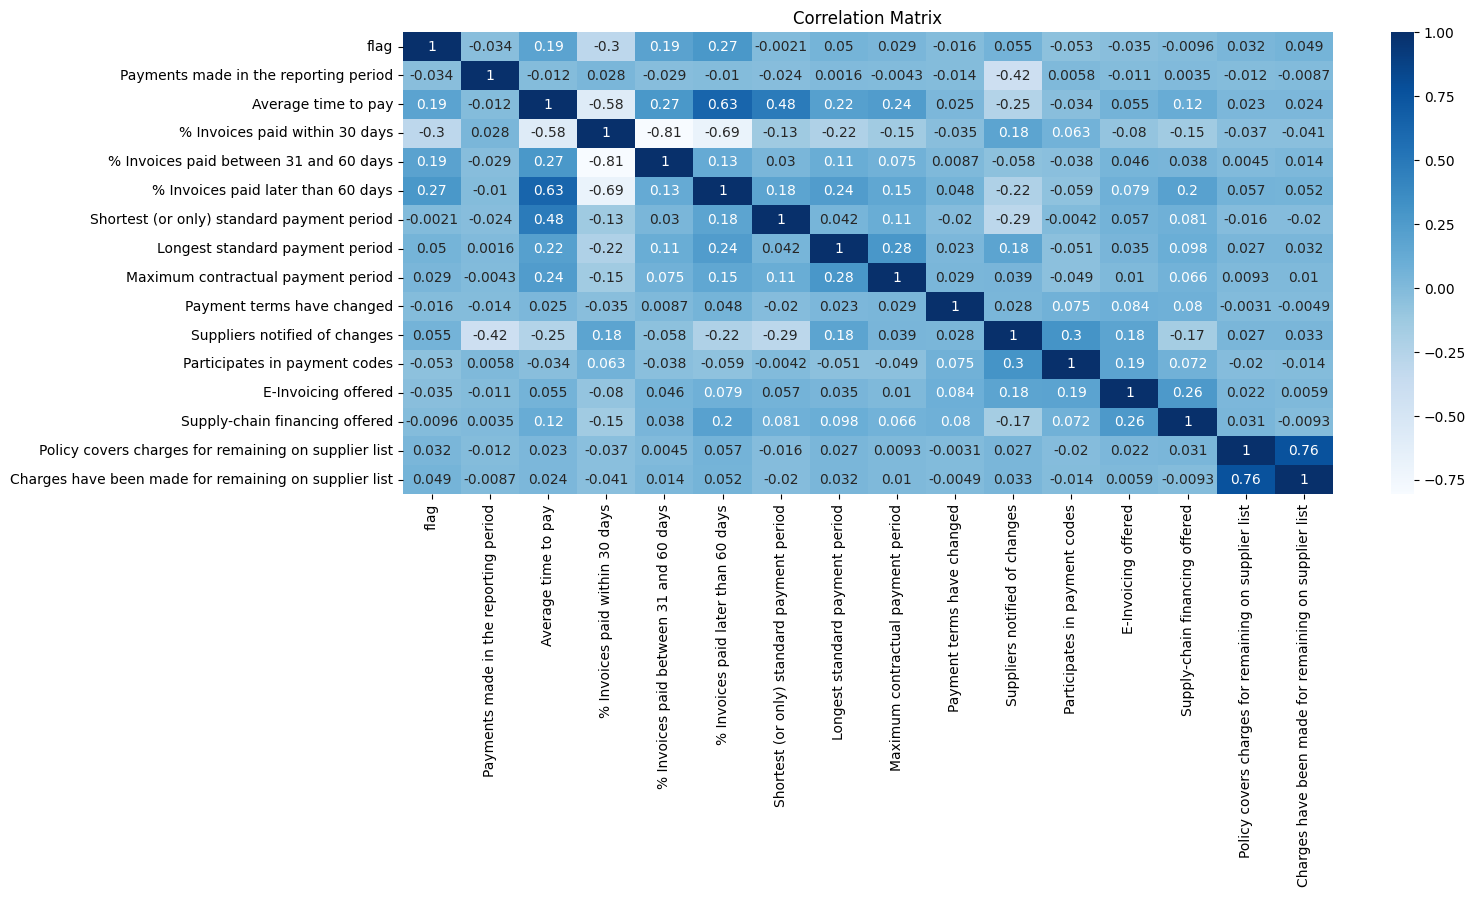

In [119]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

# Visualize the distribution of categorical columns
categorical_columns = data.select_dtypes(include=['object', 'bool']).columns
for column in categorical_columns:
    plt.figure(figsize=(15, 6))
    sns.countplot(data[column])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [120]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list',
                            'Payments made in the reporting period'])

In [121]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data1.drop(columns=['flag']), data1['flag'], test_size=0.3, random_state=42)

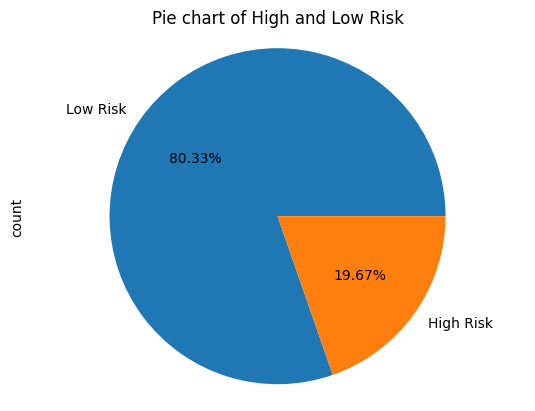

In [122]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.2f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

Random Oversampling

In [123]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_random_oversampled, y_train_random_oversampled = oversampler.fit_resample(X_train, y_train)

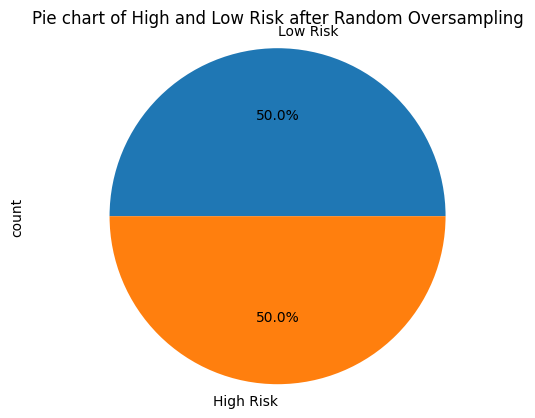

In [124]:
# pie chart of High and Low Risk after Random Oversampling
y_train_random_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

Random Undersampling

In [125]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Apply random undersampling to the training data
X_train_random_undersampled, y_train_random_undersampled = undersampler.fit_resample(X_train, y_train)

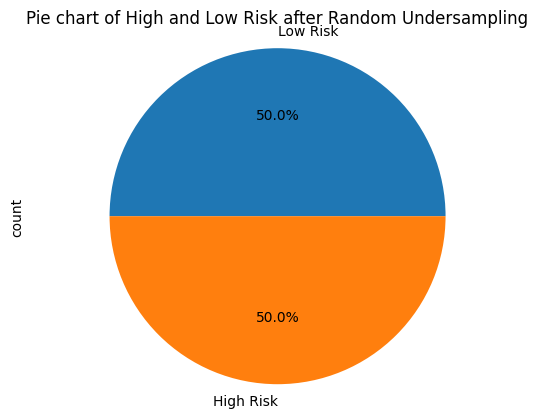

In [126]:
# pie chart of High and Low Risk after Random Undersampling
y_train_random_undersampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Undersampling')
plt.show()

SMOTE Oversampling

In [127]:
from imblearn.over_sampling import SMOTE

# Create an instance of SMOTE
smote = SMOTE(sampling_strategy='minority')

# Apply SMOTE oversampling to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


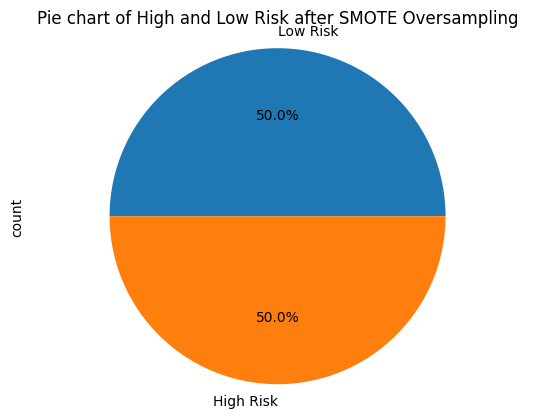

In [128]:
# pie chart of High and Low Risk after Random Undersampling
y_train_smote.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after SMOTE Oversampling')
plt.show()

XGBoost

In [129]:
# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

In [130]:
xgb_ru = XGBClassifier(**params)

xgb_ru.fit(X_train_random_oversampled, y_train_random_oversampled)

y_pred_ru = xgb_ru.predict(X_test)

# Calculate Accuracy
accuracy_ru = accuracy_score(y_test, y_pred_ru)
print('XGBoost model accuracy score: ', accuracy_ru)

# Calculate F1 Score
f1_ru = f1_score(y_test, y_pred_ru)
print('F1 Score:', f1_ru)

# Calculate AUC
fpr_ru, tpr_ru, _ = roc_curve(y_test, y_pred_ru)
auc_ru = auc(fpr_ru, tpr_ru)
print('AUC:', auc_ru)

XGBoost model accuracy score:  0.7772685609532539
F1 Score: 0.5323925593329057
AUC: 0.7349556687417468


In [131]:
xgb_rd = XGBClassifier(**params)

xgb_rd.fit(X_train_random_undersampled, y_train_random_undersampled)

y_pred_rd = xgb_rd.predict(X_test)

# Calculate Accuracy
accuracy_rd = accuracy_score(y_test, y_pred_rd)
print('XGBoost model accuracy score: ', accuracy_rd)

# Calculate F1 Score
f1_rd = f1_score(y_test, y_pred_rd)
print('F1 Score:', f1_rd)

# Calculate AUC
fpr_rd, tpr_rd, _ = roc_curve(y_test, y_pred_rd)
auc_rd = auc(fpr_rd, tpr_rd)
print('AUC:', auc_rd)

XGBoost model accuracy score:  0.7205927283837458
F1 Score: 0.5074064099111231
AUC: 0.7343781464283847


In [132]:
xgb_smote = XGBClassifier(**params)

xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xgb_smote.predict(X_test)

# Calculate Accuracy
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print('XGBoost model accuracy score: ', accuracy_smote)

# Calculate F1 Score
f1_smote = f1_score(y_test, y_pred_smote)
print('F1 Score:', f1_smote)

# Calculate AUC
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_smote)
auc_smote = auc(fpr_smote, tpr_smote)
print('AUC:', auc_smote)

XGBoost model accuracy score:  0.8156125878399022
F1 Score: 0.5208416038110362
AUC: 0.7051629267494426


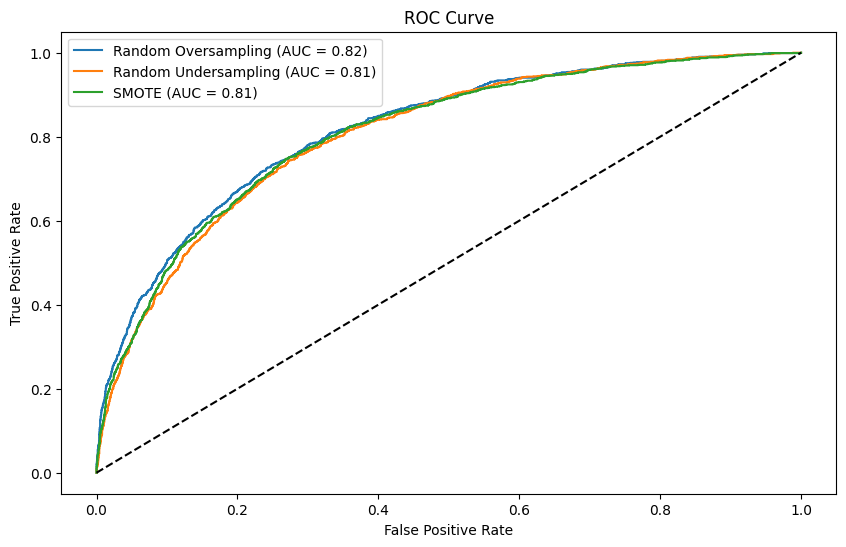

In [133]:
# Define the predicted probabilities for each model
y_pred_ru = xgb_ru.predict_proba(X_test)[:, 1]
y_pred_rd = xgb_rd.predict_proba(X_test)[:, 1]
y_pred_smote = xgb_smote.predict_proba(X_test)[:, 1]

# Calculate the ROC curve for each model
fpr_ru, tpr_ru, _ = roc_curve(y_test, y_pred_ru)
fpr_rd, tpr_rd, _ = roc_curve(y_test, y_pred_rd)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_smote)

# Calculate the AUC for each model
auc_ru = auc(fpr_ru, tpr_ru)
auc_rd = auc(fpr_rd, tpr_rd)
auc_smote = auc(fpr_smote, tpr_smote)

# Plot the ROC curve for each model
plt.figure(figsize=(10, 6))
plt.plot(fpr_ru, tpr_ru, label=f'Random Oversampling (AUC = {auc_ru:.2f})')
plt.plot(fpr_rd, tpr_rd, label=f'Random Undersampling (AUC = {auc_rd:.2f})')
plt.plot(fpr_smote, tpr_smote, label=f'SMOTE (AUC = {auc_smote:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [134]:
# Comparing the models
results = pd.DataFrame({
    'Model': ['Random Oversampling', 'Random Undersampling', 'SMOTE'],
    'Accuracy': [accuracy_ru, accuracy_rd, accuracy_smote],
    'F1 Score': [f1_ru, f1_rd, f1_smote],
    'AUC': [auc_ru, auc_rd, auc_smote]
})
results

,Model,Accuracy,F1 Score,AUC
0,Random Oversampling,0.777269,0.532393,0.817536
1,Random Undersampling,0.720593,0.507406,0.805367
2,SMOTE,0.815613,0.520842,0.808596
